In [1]:
!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy gensim wordcloud datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 19.8 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=c0ef5d48ca7dce7300ff138b2da7a7f74aaef47180c459dd9a68ada8279c8f1d
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uni

In [2]:
import tiktoken
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
from datasets import load_dataset
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from nltk import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Dataset loading

In [3]:
dataset = load_dataset("yaful/DeepfakeTextDetect")

# Load the train dataset
df = dataset["train"].to_pandas()
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/319071 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/56792 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/56819 [00:00<?, ? examples/s]

Generating test_ood_gpt split:   0%|          | 0/1562 [00:00<?, ? examples/s]

Generating test_ood_gpt_para split:   0%|          | 0/2362 [00:00<?, ? examples/s]

,text,label,src
0,White girls very rarely date Asian men. Even i...,1,cmv_human
1,I am a 23 year old male Indian American male. ...,1,cmv_human
2,"Take three people, Persons A, B, and C. They l...",1,cmv_human
3,(A) Work part-time in high school; Then go to ...,1,cmv_human
4,When police introduce a new form of speed prev...,1,cmv_human


Text(0.5, 1.0, 'Data Distribution')

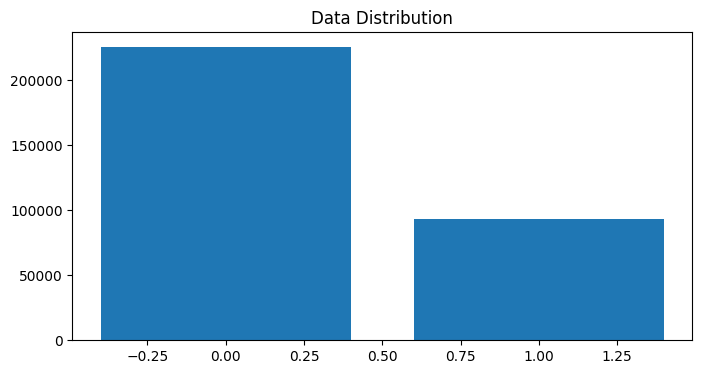

In [4]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data Distribution")

## Preprocessing

In [5]:
def preprocess_text(text):
    # Text to lowercase
    text = text.lower()

    list_text = text.split()

    # Remove stopwords
    list_stopwords = set(nltk.corpus.stopwords.words("english"))
    list_text = [word for word in list_text if word not in list_stopwords]

    # Lemmetize
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    list_text = [lem.lemmatize(word) for word in list_text]

    text = " ".join(list_text)
    return text

## Training Word2Vec

In [6]:
# Check if df.pkl exists
try:
    df = pd.read_pickle("df.pkl")
except:
    df["text_preprocess"] = df["text"].apply(lambda x: preprocess_text(x))
    df.to_pickle("df.pkl")

In [7]:
# Save time when retry new model
if "df" not in locals():
    df = pd.read_pickle("df.pkl")
X_list = list(df["text_preprocess"])
X_strings = " ".join(X_list)
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]
X_sents

[['white', 'girl', 'rarely', 'date', 'asian', 'men', '.'],
 ['even', 'asia', 'white', 'men', 'much', 'popular', 'asian', 'men', '.'],
 ['even',
  'though',
  'asian',
  'guy',
  'may',
  'preference',
  'white',
  'girl',
  'much',
  'chance',
  'one',
  'instead',
  'pursue',
  'non-white',
  'girl',
  '.'],
 ['asian',
  'guy',
  'penalized',
  'look',
  'see',
  'significantly',
  'le',
  'social',
  ',',
  'athletic',
  ',',
  'intelligent',
  ',',
  'wealthy',
  ',',
  'etc',
  '.'],
 ['facial', 'look', 'genetic', 'can', 'not', 'changed', 'easily', '.'],
 ['fit', 'body', 'help', 'nearly', 'much', 'white', 'black', 'guys', '.'],
 ['wish', 'true', '.'],
 ['edit',
  ':',
  'basically',
  'i',
  "'m",
  'saying',
  'asian',
  'men',
  'significant',
  'disadvantage',
  'dating',
  'scene',
  'especially',
  'attracted',
  'white',
  'women',
  ',',
  'comment',
  'far',
  'seem',
  'confirming',
  'view',
  '.'],
 ['hello', ',', 'user', 'cmv', '!'],
 ['footnote', 'moderators', '.'],
 [

In [8]:
model = Word2Vec(sentences=X_sents, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

## Training a classifier

In [9]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])

    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [10]:
X = df["text_preprocess"]
y = df["label"]

wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
X = np.array([document_vector(doc, wv) for doc in X])

X_train, X_test, y_train, y_test = train_test_split(X, df.label, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
print(f"Features dimension: {X_train.shape}")

Features dimension: (255256, 100)


In [11]:
classifier = LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000)

In [12]:
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.77     45073
           1       0.50      0.69      0.58     18742

    accuracy                           0.71     63815
   macro avg       0.67      0.70      0.68     63815
weighted avg       0.75      0.71      0.72     63815



## Plot confusion matrix

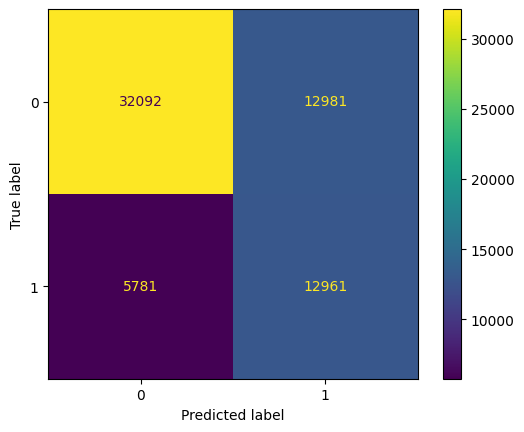

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1])
disp.plot()
plt.show()

## Optimize hyperparameters using Grid Search

In [14]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py", line 1388, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py", line 1275, in _count_vocab
    for feature in analyze(doc):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py", line 111, in _analyze
    doc = preprocessor(doc)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py", line 69, in _preprocess
    doc = doc.lower()
AttributeError: 'numpy.ndarray' object has no attribute 'lower'
